In [15]:
using Plots, LsqFit, TwoFAST, Dierckx, Printf, LaTeXStrings

In [7]:
power_law(x, si, b, a) = a .+ b .* (x .^ si)

function power_law_b_a(xs, ys, si, p0; con = false)
     if con == true
          @assert length(p0) == 2 " b, a to be fitted, so length(p0) must be 2!"
          fit = curve_fit((x, p) -> power_law(x, si, p[1], p[2]), xs, ys, p0)
          return coef(fit)
     else
          @assert length(p0) == 1 " b to be fitted, so length(p0) must be 1!"
          fit = curve_fit((x, p) -> power_law(x, si, p[1], 0.0), xs, ys, p0)
          return vcat(coef(fit), 0.0)
     end
end;

In [190]:
function power_law_from_data(
        xs::Vector{Float64}, 
        ys::Vector{Float64}, 
        P0::Vector{Float64}, 
        x1::Number, x2::Number; con = false)
    
     @assert length(xs) == length(ys) "xs and ys must have same length"
    @assert length(P0) ∈ [2, 3] "length of P0 must be 2 or 3!"
    
    #p0 = abs(P0[1]) < 1.5 ? P0 : [ P0[1] - floor() , P0[2:end]...]
    p0=P0
    
     mean_exp_xs = sum([log10(abs(x)) for x in xs[x1.<xs.<x2]]) / length(xs[x1.<xs.<x2])
     en_xs = 10.0^(-mean_exp_xs)
     new_xs = xs[x1.<xs.<x2] .* en_xs

     mean_exp_ys = sum([log10(abs(y)) for y in ys[x1.<xs.<x2]]) / length(ys[x1.<xs.<x2])
     en_ys = 10.0^(-mean_exp_ys)
     new_ys = ys[x1.<xs.<x2] .* en_ys
    
    mean_ys = sum(new_ys)/length(new_ys)
    @assert !all([isapprox(y/mean_ys, 1.0, rtol=1e-6) for y in new_ys]) "DO NOT WORK!"
     #si = mean_spectral_index(xs, ys; N=N, con=con)
    
    if con==false
        @assert length(p0) == 2 " si,b to be fitted, so length(p0) must be 2!"
        vec = coef(curve_fit((x, p) -> power_law(x, p[1], p[2], 0.0),
            new_xs, new_ys, p0))
        si, b, a = vcat(vec, 0.0)
        return si, b * (en_xs ^ si) / en_ys, a / en_ys
        
    else
        
        @assert length(p0) == 3 " si,b,a to be fitted, so length(p0) must be 3!"
        
        try
            fit_1 = curve_fit((x, p) -> power_law(x, p[1], p[2], p[3]),
                new_xs, new_ys, p0)
            vals_1 = coef(fit_1)
            stds_1 = stderror(fit_1)
            pers_1 = [s/v for (s,v) in zip(stds_1, vals_1)]
        
            si, b, a = 
                if all(x->x<0.05, pers_1) 
                    vals_1 
                elseif pers_1[3] < 0.05 
                    fit_2 = curve_fit((x, p) -> power_law(x, p[1], p[2], vals_1[3]),
                        new_xs, new_ys, p0)
                    vals_2 = coef(fit_2)
                    vcat(vals_2, vals_1[3])
                else
                    fit_3 = curve_fit((x, p) -> power_law(x, p[1], p[2], 0.0),
                        new_xs, new_ys, p0)
                    vals_3 = coef(fit_3)
                    fit_4 = curve_fit((x, p) -> power_law(x, vals_3[1], vals_3[2], p[3]),
                        new_xs, new_ys, p0)
                    vals_4 = coef(fit_4)
                
                    vcat(vals_3, vals_4)
                end
        
            return si, b * (en_xs ^ si) / en_ys, a / en_ys
            
        catch e
            fit_3 = curve_fit((x, p) -> power_law(x, p[1], p[2], 0.0),
                        new_xs, new_ys, [p0[1], p0[2]])
            si, b, a = vcat(coef(fit_3), 0.0)
            
            return si, b * (en_xs ^ si) / en_ys, a / en_ys
        end
    end
end;



function power_law_from_data(
        xs::Vector{Float64}, 
        ys::Vector{Float64}, 
        p0::Vector{Float64}; con = false)
     power_law_from_data(xs, ys, p0, xs[begin], xs[end]; con = con)
end;

In [197]:
si, b, a = -2.65, 1.54e3, 2.34563e-15
XS = 10 .^ range(4, 6, length=100)
YS = [a + b * x ^ (si)  for x in xs]
p0 = [-1.0, 1.0, 1.0]
c_si, c_b, c_a = power_law_from_data(XS, YS, p0; con = true)
calc_ys = [power_law(x, c_si, c_b, c_a) for x in XS]
c_si, c_b, c_a

(-2.6499999999999964, 1539.9999999999495, 2.3456299972577347e-15)

In [185]:
V = [1.0000918954805926, 1.000069362771451, 1.000052037821184, 1.0000387170127594, 1.0000284749090682, 1.0000205999599903, 1.0000145450688418, 1.000009889583904, 1.0000063100744667, 1.0000035578611137, 1.0000014417392054, 0.9999998146953115, 0.9999985636937402, 0.9999976018236042, 0.9999968622608573, 0.9999962936258241, 0.9999958564136979, 0.9999955202500216, 0.9999952617804814, 0.9999950630484113, 0.9999949102472898, 0.9999947927615576, 0.9999947024291234, 0.9999946329743178, 0.9999945795719042, 0.9999945385118545, 0.9999945069416019, 0.9999944826678647, 0.9999944640042729, 0.9999944496542098, 0.9999944386207326, 0.9999944301373123, 0.9999944236145796, 0.9999944185993809, 0.9999944147432944, 0.9999944117784267, 0.999994409498799, 0.9999944077460389, 0.9999944063983766, 0.9999944053621858, 0.9999944045654795, 0.999994403952908, 0.9999944034819139, 0.999994403119776, 0.9999944028413355, 0.999994402627248, 0.9999944024626404, 0.9999944023360768, 0.9999944022387649, 0.9999944021639435, 0.9999944021064148, 0.9999944020621822, 0.9999944020281725, 0.9999944020020233, 0.9999944019819176, 0.9999944019664588, 0.9999944019545728, 0.999994401945434, 0.9999944019384072, 0.9999944019330045, 0.9999944019288504, 0.9999944019256565, 0.9999944019232008, 0.9999944019213125, 0.9999944019198607, 0.9999944019187444, 0.9999944019178862, 0.9999944019172262, 0.9999944019167188, 0.9999944019163287, 0.9999944019160287, 0.9999944019157982, 0.9999944019156208, 0.9999944019154845, 0.9999944019153797, 0.9999944019152992, 0.9999944019152371, 0.9999944019151895, 0.9999944019151529, 0.9999944019151246, 0.9999944019151031, 0.9999944019150863, 0.9999944019150735, 0.9999944019150637, 0.9999944019150562, 0.9999944019150503, 0.999994401915046, 0.9999944019150424, 0.9999944019150397, 0.9999944019150376, 0.9999944019150362, 0.999994401915035, 0.999994401915034, 0.9999944019150333, 0.9999944019150327, 0.9999944019150323, 0.999994401915032]
mean_V = sum(V)/length(V)
@assert !all([isapprox(y/mean_V, 1.0, rtol=1e-12) for y in V]) "DO NOT WORK!"
[isapprox(y/mean_V, 1.0, rtol=1e-4) for y in V]

97-element Vector{Bool}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

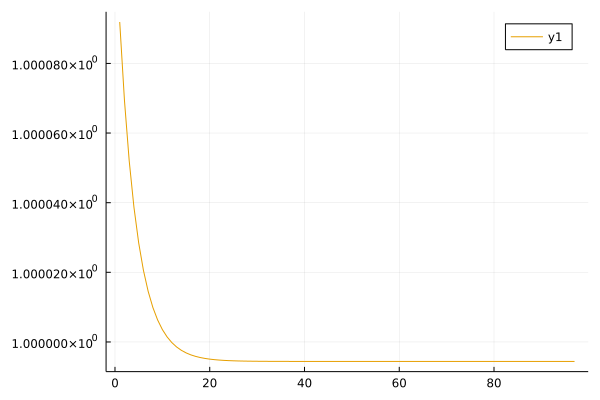

In [186]:
plot(V)

In [159]:
xs = XS
ys = YS
x1, x2 = xs[begin], xs[end]
mean_exp_xs = sum([log10(abs(x)) for x in xs[x1.<xs.<x2]]) / length(xs[x1.<xs.<x2])
en_xs = 10.0^(-mean_exp_xs)
new_xs = xs[x1.<xs.<x2] .* en_xs

mean_exp_ys = sum([log10(abs(y)) for y in ys[x1.<xs.<x2]]) / length(ys[x1.<xs.<x2])
en_ys = 10.0^(-mean_exp_ys)
new_ys = ys[x1.<xs.<x2] .* en_ys
ys

100-element Vector{Float64}:
 2.34563e10
 2.34563e10
 2.34563e10
 2.34563e10
 2.34563e10
 2.34563e10
 2.34563e10
 2.34563e10
 2.34563e10
 2.34563e10
 2.34563e10
 2.34563e10
 2.34563e10
 ⋮
 2.34563e10
 2.34563e10
 2.34563e10
 2.34563e10
 2.34563e10
 2.34563e10
 2.34563e10
 2.34563e10
 2.34563e10
 2.34563e10
 2.34563e10
 2.34563e10

In [138]:
#plot(new_xs, new_ys)

In [139]:
#=
fit1 = curve_fit((x, p) -> power_law(x, p[1], p[2], 0.0),
                    new_xs, new_ys, [1.0, 1.0])
S, B = coef(fit)[1], coef(fit)[2] 
fit2 = curve_fit((x, p) -> power_law(x, S, B, p[1]),
                    new_xs, new_ys, [1.0])
println(coef(fit1) .* [1.0, (en_xs ^ coef(fit1)[1]) / en_ys])
println(coef(fit2)./ en_ys)
stderror(fit1), stderror(fit2)./ en_ys
=#

In [140]:
fit_3 = curve_fit((x, p) -> power_law(x, p[1], p[2], p[3]),
                    new_xs, new_ys, [1.0, 1.0, 1.0])
println(coef(fit_3) .* [1.0, (en_xs ^ coef(fit1)[1]) / en_ys, 1/en_ys])
println(stderror(fit_3).* [1.0, (en_xs ^ coef(fit1)[1]) / en_ys, 1/en_ys])

[0.3344557564587318, 2.294065252425042e-18, 2.345629999999995e10]


LoadError: LinearAlgebra.LAPACKException(1)

In [ ]:
[s/v for (s,v) in zip(coef(fit_3))]

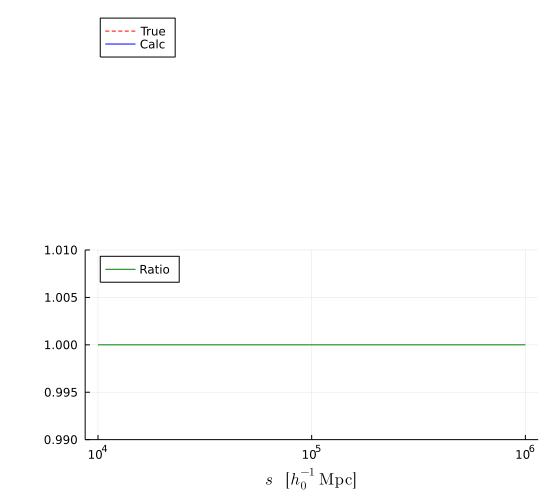

In [ ]:
true_xs = XS
true_ys = YS
xs = XS
ys = calc_ys
spline = Spline1D(xs, ys)

S_VLIM = 1.0
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot(
    [true_xs[true_ys .> 0], xs[ys .> 0]], 
    [true_ys[true_ys .> 0], ys[ys .> 0]], 
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], 
    label=["True" "Calc"], ls=[:dash :solid], 
    legend=:topleft)
#vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(true_xs, spline.(true_xs) ./ true_ys, label="Ratio", lc=:green, 
    xaxis=:log,
    ylim=(0.99,1.01), legend=:topleft,
    xlabel=L"$s \quad [h_0^{-1}\,\mathrm{Mpc}]$")
#vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(550, 500), layout= @layout [ x ; z ] )